# Tutorial

Jelle, updated May 2019

This notebook shows how to do basic analysis with straxen, much like `hax.minitrees`.

For reference, here are some jargon terms which we will introduce below:

  * **Context**: Holds configuration on how to process
  * **Dataframe** or **array**: table of related information produced by a plugin.
  * **Plugin**: an algorithm that produces a dataframe
  * **Data type**: specification of which columns are in a dataframe. 
  * **Data kind**: e.g. 'events' or 'peaks'. Dataframes of the same kind  have the same number of rows and can be merged.


In [1]:
import numpy as np
# This just ensures some comments in dataframes below display nicely
import pandas as pd
pd.options.display.max_colwidth = 100

## Setting up

First we load a strax **context**, much like `hax.init()`. A strax context contains all information on *how* to process: where to read what files from, what plugins provide what data, etc. 

You can make a context yourselves using `strax.Context`, but straxen provides standardized contexts as well. Most future analyses will use such standardized contexts defined by analysis coordinators or straxen maintainers.

Unlike `hax.init`, you can have multiple active contexts, e.g. to load analysis and MC data, or compare data processed with different settings (we will see examples of this below).

In [2]:
import straxen
st = straxen.contexts.demo()

## Finding your data

Suposse we want to make a cS1/cS2 plot. We have to figure out which type of **dataframes** to load. A specific type of dataframe is also called a **data type**. (in hax these were called minitrees)

We can find this out automatically if we know (part of) the name of a field to load:

In [3]:
st.search_field('cs1')

cs1 is part of corrected_areas (provided by CorrectedAreas)
cs1 is part of event_info (provided by EventInfo)
cs1 is part of fiducial_events (provided by FiducialEvents)


It seems we're after one of the data types called `event_info` or `corrected_areas`. In the current context, these are provided by **plugins** called EventInfo and CorrectedAreas, respectively (but this doesn't concern us yet). 

Let's see what else is in these data types:

In [4]:
st.data_info('event_info')

,Field name,Data type,Comment
0,event_number,int64,Event number in this dataset
1,time,int64,Event start time in ns since the unix epoch
2,endtime,int64,Event end time in ns since the unix epoch
3,n_peaks,int32,Number of peaks in the event
4,drift_time,int64,Drift time between main S1 and S2 in ns
5,s1_index,int32,Main S1 peak index
6,s1_area,float32,"Main S1 area (PE), uncorrected"
7,s1_area_fraction_top,float32,Main S1 area fraction top
8,s1_range_50p_area,float32,"Main S1 width (ns, 50% area)"
9,s1_n_competing,int32,Main S1 number of competing peaks


As you can see, `event_info` has a lot more information; let's load that one. You can see from the documentation (TODO link) that `event_info`'s job is to merge the info from `corrected_areas` and other things.


## Loading data

Next, you'll want to select a run. The `select_runs` function will return a dataframe with all available runs; there is a separate tutorial on more advanced use of this. In this demo context, we only have high-level data for the run `180215_1029` available (and low-level data for another):

In [5]:
st.select_runs()

Checking data availability: 100%|██████████| 5/5 [00:00<00:00, 33.55it/s]


,mode,name,number,tags,records_available,peaks_available,raw_records_available,event_info_available,events_available
0,,180215_1029,1802151029,,False,True,False,True,True
1,,180423_1021,1804231021,,True,True,True,False,False


So lets' take that 180215_1029.

To actually load data, you use `get_df` to get a pandas DataFrame, or `get_array` to get a numpy (structured) array. Let's go with pandas for now:

In [6]:
run_id = '180215_1029'
df = st.get_df(run_id, 'event_info')

The first time you run this, it will take a moment: it has to actually process the data somewhat. We didn't ship highest-level demo data with straxen: that would mean we'd have to constantly update the test data when the algorithms change.

You can also specify a list of runid's instead of one run, and get the concatenated result back. Likewise, you can specify multiple data types (of the same kind) to load, and they will be merged for you.

Just like hax.minitrees.load, we got a dataframe back:

In [7]:
st.show_config('event_info')

,option,default,current,applies_to,help
0,trigger_min_area,100,<OMITTED>,"(events,)",Peaks must have more area (PE) than this to cause events
1,trigger_max_competing,7,<OMITTED>,"(events,)",Peaks must have FEWER nearby larger or slightly smaller peaks to cause events
2,left_event_extension,1000000,<OMITTED>,"(events,)",Extend events this many ns to the left from each triggering peak
3,right_event_extension,1000000,<OMITTED>,"(events,)",Extend events this many ns to the right from each triggering peak
4,n_top_pmts,127,<OMITTED>,"(peak_basics,)",Number of top PMTs
5,peak_gap_threshold,300,<OMITTED>,"(peaks,)",No hits for this many ns triggers a new peak
6,peak_left_extension,30,<OMITTED>,"(peaks,)",Include this many ns left of hits in peaks
7,peak_right_extension,30,<OMITTED>,"(peaks,)",Include this many ns right of hits in peaks
8,peak_min_pmts,2,<OMITTED>,"(peaks,)",Minimum contributing PMTs needed to define a peak
9,single_channel_peaks,False,<OMITTED>,"(peaks,)",Whether single-channel peaks should be reported


In [8]:
df.head()

,event_number,time,endtime,n_peaks,drift_time,s1_index,s1_area,s1_area_fraction_top,s1_range_50p_area,s1_n_competing,...,r,z_naive,r_naive,r_field_distortion_correction,theta,cs1,cs2,e_light,e_charge,e_ces
0,0,1518690592149882940,1518690592152169100,7,275600,0,3076.020996,0.259360,58.849171,1,...,44.655453,-36.723701,41.780285,2.875169,-0.153706,3396.597900,648463.625000,326.321106,284.594116,610.915222
1,1,1518690592201439770,1518690592203722350,13,255300,0,5657.061035,0.247569,59.879601,2,...,45.745533,-34.018726,42.465225,3.280305,-2.716759,6345.708496,651396.250000,609.650818,285.881165,895.531982
2,2,1518690592466567440,1518690592468799990,77,205250,0,1336.449585,0.293159,61.272530,1,...,46.867878,-27.349562,39.423969,7.443908,3.074576,1591.745361,90951.375000,152.923645,39.916233,192.839874
3,3,1518690592747771050,1518690592749798720,6,21110,0,1112.982544,0.391424,57.158356,1,...,37.097477,-2.812907,36.819721,0.277754,-2.381648,1482.538696,145756.453125,142.431839,63.968784,206.400620
4,4,1518690593003844370,1518690593005853870,2,0,-1,0.000000,0.000000,0.000000,0,...,43.119293,-0.000000,42.984917,0.134375,1.392594,0.000000,119103.554688,0.000000,52.271507,52.271507


Let's make a quick plot of the events we just loaded:

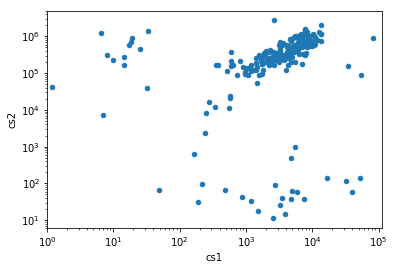

In [9]:
df.plot.scatter('cs1', 'cs2')

import matplotlib.pyplot as plt
plt.xscale('log')
plt.xlim(1, None)
plt.yscale('log')

Since making a cS1, cS2 plot for a dataset is such a common task that straxen has a built-in method for it. There are other similar mini-analyses, such a waveform plotting, which we will see in action below.

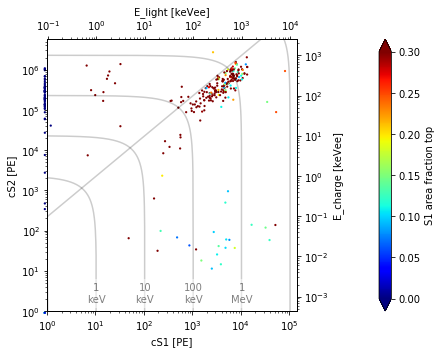

In [10]:
st.event_scatter(run_id, s=20)

Can you guess what kind of data this is?

## Waveform analysis

The *peaks* data type contains the sum waveform information:

In [11]:
st.data_info('peaks')

,Field name,Data type,Comment
0,channel,int16,Channel/PMT number
1,dt,int16,Time resolution in ns
2,time,int64,Start time of the interval (ns since unix epoch)
3,length,int32,Length of the interval in samples
4,area,float32,Integral across channels in photoelectrons
5,area_per_channel,"('<f4', (248,))",Integral per channel in PE
6,n_hits,int32,Number of hits from which peak was constructed (currently zero if peak is split afterwards)
7,data,"('<f4', (200,))",Waveform data in PE/sample (not PE/ns!)
8,width,"('<f4', (11,))",Peak widths in ns: range of central area fraction
9,area_decile_from_midpoint,"('<f4', (11,))",Peak widths in ns: area from midpoint


Notice the compound data types of the `data`, `width` and `saturated_channel` fields. Pandas does not support such types (well, it sort of does, but the resulting dataframes are quite inefficient), so we have to load this as a numpy array.

In [12]:
peaks = st.get_array(run_id, ['peaks', 'peak_classification'])
type(peaks), peaks.dtype.names

(numpy.ndarray,
 ('channel',
  'dt',
  'time',
  'length',
  'area',
  'area_per_channel',
  'n_hits',
  'data',
  'width',
  'area_decile_from_midpoint',
  'saturated_channel',
  'n_saturated_channels',
  'type'))

Note we merged in the peak_classification datatype, which added the extra 'type' field:

In [13]:
st.data_info('peak_classification')

,Field name,Data type,Comment
0,type,int8,Classification of the peak.


Now we can plot peak waveforms:

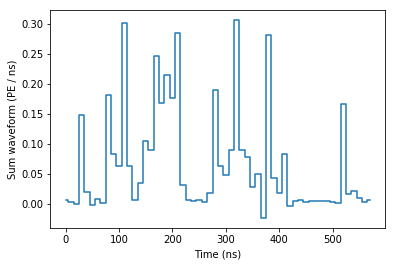

In [14]:
def plot_peak(p, t0=None, **kwargs):
    n = p['length']
    if t0 is None:
        t0 = p['time']
    plt.plot((p['time'] - t0) + np.arange(n) * p['dt'], 
             p['data'][:n] / p['dt'], 
             linestyle='steps-mid',
             **kwargs)
    plt.xlabel("Time (ns)")
    plt.ylabel("Sum waveform (PE / ns)")

plot_peak(peaks[9100])

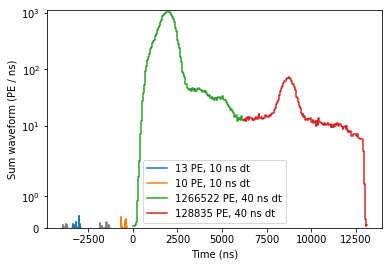

In [15]:
def plot_peaks(main_i, n_before=0, n_after=0, label_threshold=0):
    for i in main_i + np.arange(-n_before, n_after + 1):
        p = peaks[i]
        label = None
        if p['area'] > label_threshold:
            label = '%d PE, %d ns dt' % (p['area'], p['dt'], )
            color = None
        else:
            color = 'gray'
        plot_peak(p,
                  t0=peaks[main_i]['time'],
                  label=label,
                  color=color)
    plt.ylim(0, None)
    plt.legend(loc='best')
    plt.yscale('symlog')

plot_peaks(27595, n_after=1, n_before=4, label_threshold=10)

The abrupt termination of the S2 above is due to strax's data reduction.

If you have access to the raw data (at least the `records` level) you can use straxen's built-in waveform display. For example, try:

```python
st.waveform_display('180423_1021', seconds_range=(0, 0.15))
```

(we didn't evaluate this in the tutorial, as it creates a substantial amount of javascript, which would have made the notebook quite huge).

## Configuration changes

As you can see in the above plot, we have many events high up in the TPC at low S1. Perhaps you want to get rid of them by increasing the 'S1 coincidence requirement', i.e. the number of PMTs that must see something before a peak is labeled as S1. Then, of course, you want to load the event-level data again to see if it worked.

First, we need to see which configuration option we have to change. Strax plugins declare what configuration they take and what other plugins they depend on, so this is not very difficult. We just ask which options with `s1` in their name influence `event_basics`:

In [16]:
st.show_config('event_basics', 's1*')

,option,default,current,applies_to,help
0,s1_max_width,150,<OMITTED>,"(peak_classification,)",Maximum (IQR) width of S1s
1,s1_min_n_channels,3,<OMITTED>,"(peak_classification,)",Minimum number of PMTs that must contribute to a S1


Looks like we're after the `s1_min_n_channels option`. Note this is not part of the `event_basics` data type, but of a data type called `peak_classification`. As you can see from the table, this option is not set in the current context, so the default value (3) is used.

To try out a different option, just pass it to get_df:

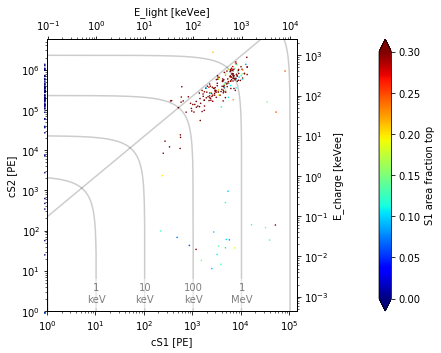

In [17]:
df_2 = st.get_df(run_id, 'event_info',
                 config=dict(s1_min_n_channels=50))
st.event_scatter(run_id, events=df_2)

Notice all the small S1 events are indeed gone now.

Behind the scenes, this figured out which dataframes had to be remade: as it happens this time just `event_basics` and `peak_basics`. You will now have a new `event_basics_<somehash>` folder in `./custom_data` which contains the results, as well as a new `peak_basics_<somehash> folder`.

### More on configuration changes

Changing configuration can be done in two other ways. We can change it permanently in the current context:
```python
st.set_config(dict(s1_min_channels=50))
```
Or we could make a new context, with this option set:
```python
st_2 = st.new_context(config=dict(s1_min_channels=50))
```
(feeding it to get_df just does the latter behind the scenes).

If you just want to run a mini-analysis (like `event_scatter`), you can also pass a new `config` option directly to it, as in the example below.

Strax protects you from typos in the configuration. Suppose we typed `s1_min_n_channelz` instead:

/home/jelle/software/strax/strax/context.py:344: UserWarning: Option s1_min_n_channelz not taken by any registered plugin
  warnings.warn(f"Option {k} not taken by any registered plugin")


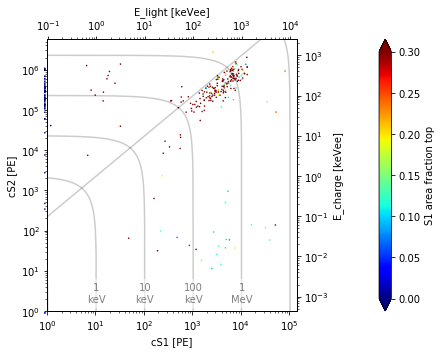

In [18]:
st.event_scatter(run_id, config=dict(s1_min_n_channelz=10))

The result of get_df is just the same as if the option wasn't set (just like in pax/hax), but you also get a warning about an unknown configuration option. 

By the way, you can use 
```python
import warnings
warnings.filterwarnings("error")
```
to ensure any warning raises an exception instead.

## Customization: new plugins

To add or change processing algorithms, or to define new variables to use in cuts, you have to write new strax plugins. These are somewhat similar to hax's treemakers.

Suppose you have a brilliant new idea for peak classification:

In [19]:
import strax
import numpy as np

class AdvancedExpertClassification(strax.Plugin):
    """Everything is an S1!"""
    
    # Name of the data type this plugin provides
    provides = 'peak_classification'
    
    # Data types this plugin requires. Note we don't specify
    # what plugins should produce them: maybe the default PeakBasics
    # has been replaced by another AdvancedExpertBlabla plugin?
    depends_on = ('peak_basics',)
    
    # Numpy datatype of the output 
    dtype = straxen.PeakClassification.dtype
    
    # Version of the plugin. Increment this if you change the algorithm.
    __version__ = '0.0.1'

    def compute(self, peaks):
        # Your code here.
        # This function will be called several times with 
        # 'peaks' a numpy array of the datatype 'peaks'.
        # Each time you'll see a small part of the run.
        
        # You have to return a numpy array of the dtype you declared above
        # or, which is often easier, a dictionary we can transform into it
        # (dict keys -> field names, values -> field values)
        return dict(type=np.ones(len(peaks)))

Notice the plugin provides 'peak_classification' and produces the same data type as PeakClassification plugin, which in this case is just:

In [20]:
AdvancedExpertClassification.dtype

[('type', numpy.int8, 'Classification of the peak.')]

To use it in place of PeakClassification, we only have to register it. Again, we can do so permanently using 
```python
st.register(AdvancedExpertClassification)
```
or temporarily, by feeding the registration as an extra argument to `get_df`:

In [21]:
df = st.get_df(run_id, 'event_info',
               register=AdvancedExpertClassification)

In [22]:
df['s2_area'].max()

0.0

As you can see, all events are now S1-only events, as expected. Maybe this is not the best alternative classification :-)

This plugin was the most basic possible plugin. You'll also want to learn about `LoopPlugin`s and `OverlapWindowPlugin`s, but that's beyond the scope of this tutorial.